In [1]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from pathlib import Path
import glob
from PIL import Image

from matplotlib.image import imread
import tensorflow as tf
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Flatten,Dropout, GlobalAveragePooling2D, BatchNormalization
from tensorflow.keras.optimizers import Adam,RMSprop,SGD,Adagrad, Adadelta,Adamax, Nadam


from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.applications import MobileNetV2, ResNet50V2, mobilenet_v2,InceptionV3
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

from tensorflow.keras.preprocessing.image import load_img,  img_to_array
import random

import warnings
warnings.filterwarnings('ignore')

2024-06-07 12:33:39.222320: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-07 12:33:39.222416: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-07 12:33:39.323431: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [33]:

# Main Folder Path
folder_path = "/kaggle/input/final-dataset-all/FINAL_DATASET_3_SPLITTED"

# Sub Folder Paths
train_path = folder_path + '/train'
val_path = folder_path + '/val'
deployment_path = folder_path + '/check'

In [23]:
os.listdir(folder_path)

['check', 'val', 'train']

In [24]:
os.listdir(train_path)

['ELECTRONICS',
 'PET_SUPPLIES',
 'BABY_PRODUCTS',
 'SPORTS_OUTDOOR',
 'HOME_KITCHEN_TOOLS',
 'HOBBY_ARTS_STATIONERY',
 'BEAUTY_HEALTH',
 'CLOTHING_ACCESSORIES_JEWELLERY',
 'GROCERY']

In [25]:
os.listdir(val_path)

['ELECTRONICS',
 'PET_SUPPLIES',
 'BABY_PRODUCTS',
 'SPORTS_OUTDOOR',
 'HOME_KITCHEN_TOOLS',
 'HOBBY_ARTS_STATIONERY',
 'BEAUTY_HEALTH',
 'CLOTHING_ACCESSORIES_JEWELLERY',
 'GROCERY']

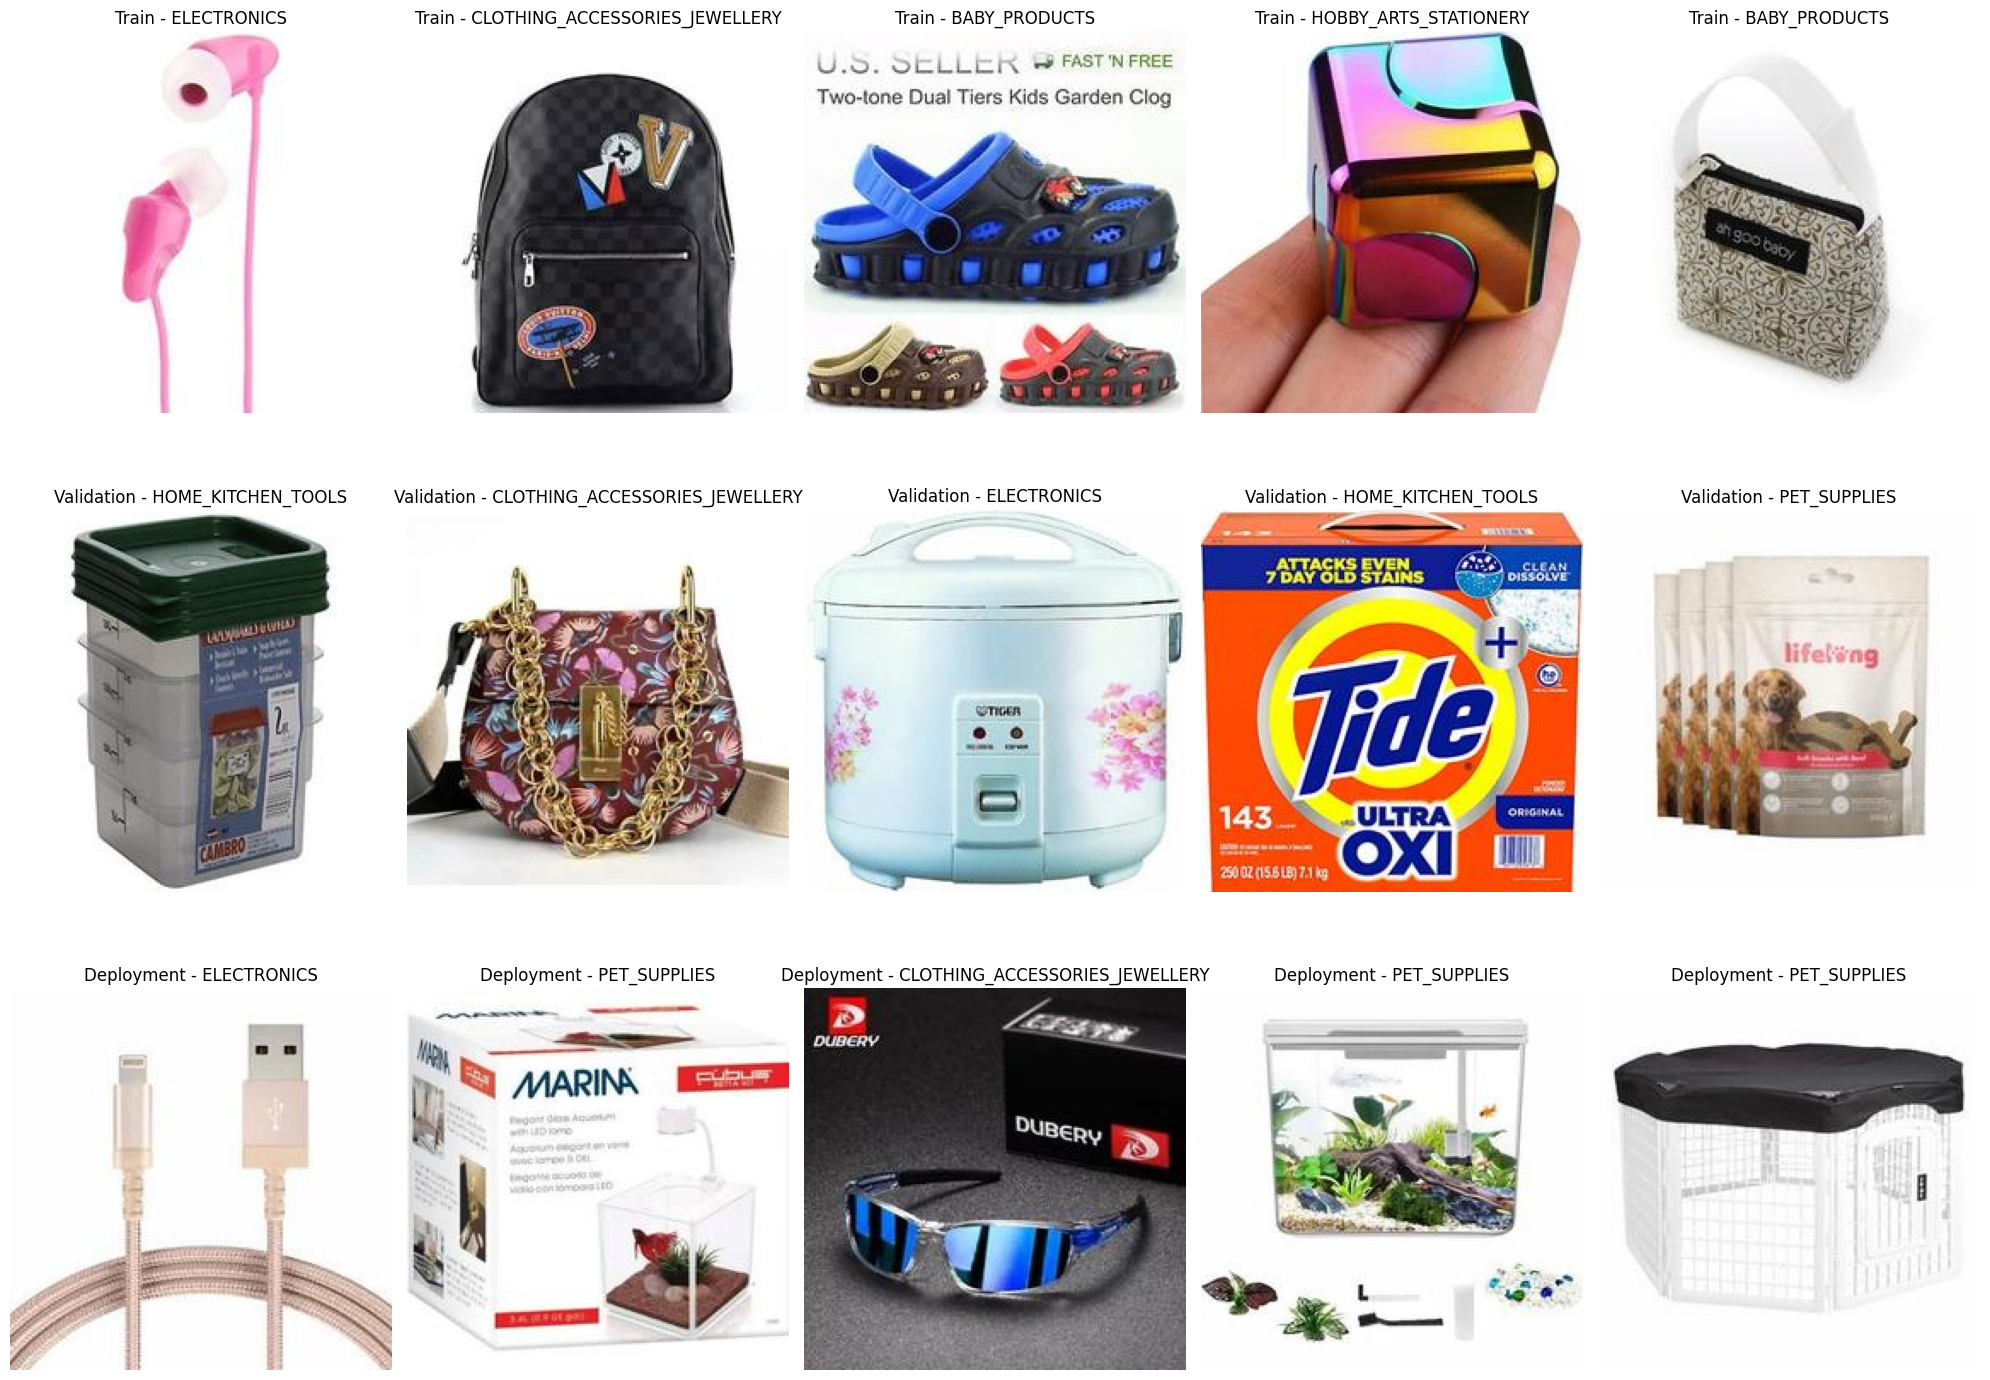

In [31]:
# Function to load random images from a path
def load_random_images_from_path(path, num_images=5):
    categories = [d for d in glob.glob(os.path.join(path, '*')) if os.path.isdir(d)]
    images = []
    for _ in range(num_images):
        random_category = random.choice(categories)
        image_files = glob.glob(os.path.join(random_category, '*'))
        if image_files:
            random_image = random.choice(image_files)
            images.append((random_image, os.path.basename(random_category)))
    return images

# Load random images
train_images = load_random_images_from_path(train_path)
val_images = load_random_images_from_path(val_path)
deployment_images = load_random_images_from_path(deployment_path)

# Display the images
fig, axes = plt.subplots(3, 5, figsize=(20, 15))  # 3 rows and 5 columns

# Display train images
for i, (image_path, category) in enumerate(train_images):
    img = Image.open(image_path)
    axes[0, i].imshow(img)
    axes[0, i].set_title(f"Train - {category}")
    axes[0, i].axis('off')

# Display val images
for i, (image_path, category) in enumerate(val_images):
    img = Image.open(image_path)
    axes[1, i].imshow(img)
    axes[1, i].set_title(f"Validation - {category}")
    axes[1, i].axis('off')

# Display deployment images
for i, (image_path, category) in enumerate(deployment_images):
    img = Image.open(image_path)
    axes[2, i].imshow(img)
    axes[2, i].set_title(f"Deployment - {category}")
    axes[2, i].axis('off')

plt.tight_layout()
plt.show()


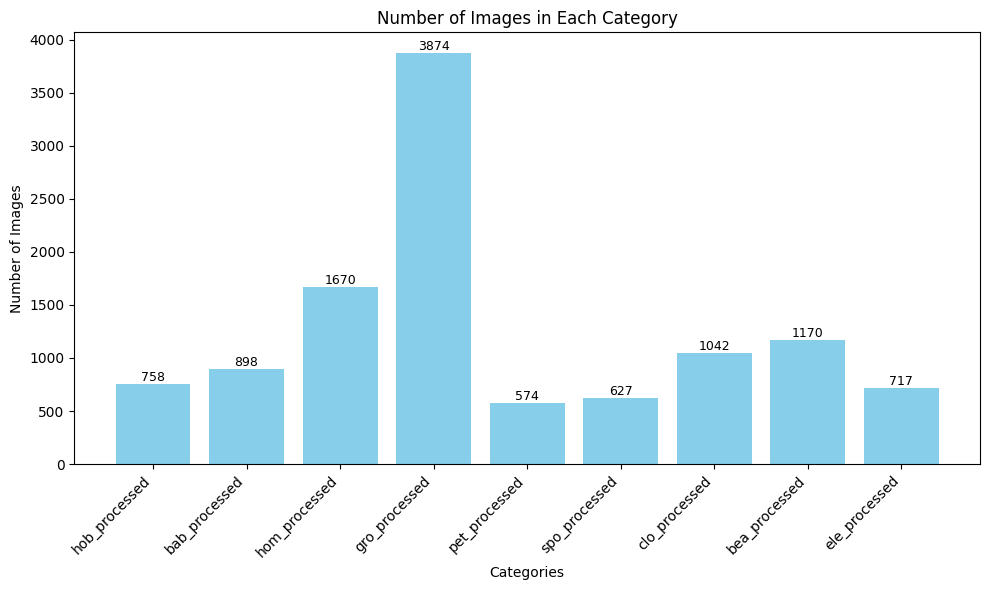

In [40]:
# FINAL_DATA_SET_1

# Main Folder Path
folder_path = "/kaggle/input/category-prediction-for-e-commerce-images-dataset/FINAL_DATASET_SPLITTED"

# Sub Folder Paths
train_path = folder_path + '/train'
val_path = folder_path + '/val'
deployment_path = folder_path + '/deployment_check'


def get_image_counts(train_path):
    category_counts = {}
    # Loop through each category folder
    for category in os.listdir(train_path):
        category_path = os.path.join(train_path, category)
        # Count the number of image files in the category folder
        image_count = sum([1 for file in os.listdir(category_path) if os.path.isfile(os.path.join(category_path, file))])
        category_counts[category] = image_count
    return category_counts

def plot_image_counts(category_counts):
    categories = list(category_counts.keys())
    counts = list(category_counts.values())
    plt.figure(figsize=(10, 6))
    bars = plt.bar(categories, counts, color='skyblue')
    plt.xlabel('Categories')
    plt.ylabel('Number of Images')
    plt.title('Number of Images in Each Category')
    plt.xticks(rotation=45, ha='right')

    # Add counts on top of each bar
    for bar, count in zip(bars, counts):
        plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), count,
                 ha='center', va='bottom', color='black', fontsize=9)

    plt.tight_layout()
    plt.show()

# Get image counts for each category
category_counts = get_image_counts(train_path)

# Plot image counts as a bar graph
plot_image_counts(category_counts)



In [43]:
# Creating an array of paths
data_paths = [val_path, train_path, deployment_path]
data_labels = ["Validation Data", "Train Data", "Deployment Check Data"]

# Looping over each dataset
for label, path in zip(data_labels, data_paths):
    print(label)
    print(get_image_counts(path))
    print("------------------------------------")


Validation Data
{'hob_processed': 203, 'bab_processed': 240, 'hom_processed': 446, 'gro_processed': 1034, 'pet_processed': 154, 'spo_processed': 168, 'clo_processed': 279, 'bea_processed': 313, 'ele_processed': 192}
------------------------------------
Train Data
{'hob_processed': 758, 'bab_processed': 898, 'hom_processed': 1670, 'gro_processed': 3874, 'pet_processed': 574, 'spo_processed': 627, 'clo_processed': 1042, 'bea_processed': 1170, 'ele_processed': 717}
------------------------------------
Deployment Check Data
{'hob_processed': 51, 'bab_processed': 60, 'hom_processed': 112, 'gro_processed': 259, 'pet_processed': 39, 'spo_processed': 42, 'clo_processed': 70, 'bea_processed': 79, 'ele_processed': 48}
------------------------------------


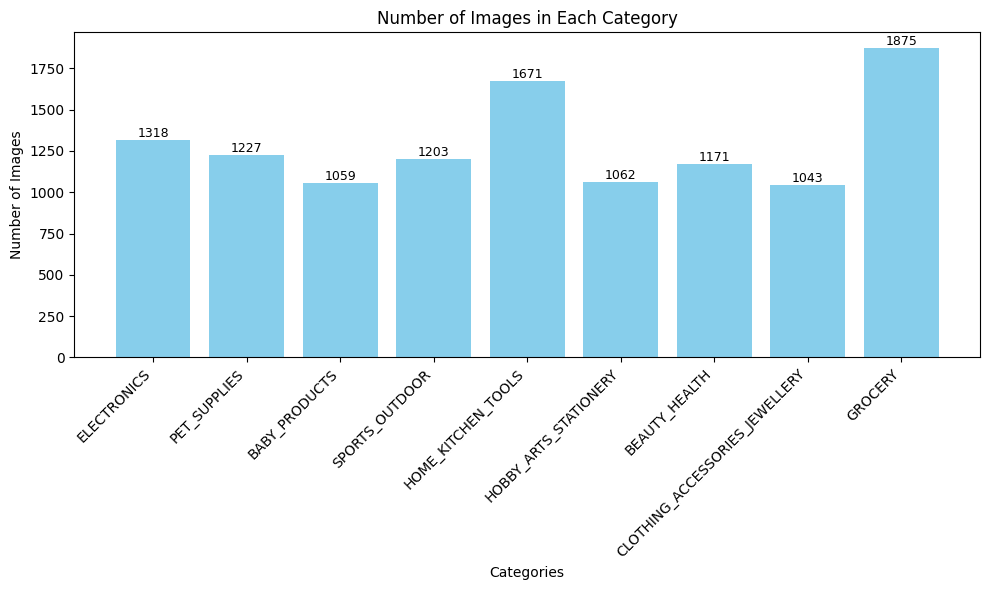

In [47]:
# FINAL_DATA_SET_2

# Main Folder Path
folder_path = "/kaggle/input/final-dataset2/FINAL_DATASET_2_SPLITTED"

# Sub Folder Paths
train_path = folder_path + '/train'
val_path = folder_path + '/val'
deployment_path = folder_path + '/check'


def get_image_counts(train_path):
    category_counts = {}
    # Loop through each category folder
    for category in os.listdir(train_path):
        category_path = os.path.join(train_path, category)
        # Count the number of image files in the category folder
        image_count = sum([1 for file in os.listdir(category_path) if os.path.isfile(os.path.join(category_path, file))])
        category_counts[category] = image_count
    return category_counts

def plot_image_counts(category_counts):
    categories = list(category_counts.keys())
    counts = list(category_counts.values())
    plt.figure(figsize=(10, 6))
    bars = plt.bar(categories, counts, color='skyblue')
    plt.xlabel('Categories')
    plt.ylabel('Number of Images')
    plt.title('Number of Images in Each Category')
    plt.xticks(rotation=45, ha='right')

    # Add counts on top of each bar
    for bar, count in zip(bars, counts):
        plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), count,
                 ha='center', va='bottom', color='black', fontsize=9)

    plt.tight_layout()
    plt.show()

# Get image counts for each category
category_counts = get_image_counts(train_path)

# Plot image counts as a bar graph
plot_image_counts(category_counts)



In [45]:
# Creating an array of paths
data_paths = [val_path, train_path, deployment_path]
data_labels = ["Validation Data", "Train Data", "Deployment Check Data"]

# Looping over each dataset
for label, path in zip(data_labels, data_paths):
    print(label)
    print(get_image_counts(path))
    print("------------------------------------")


Validation Data
{'ELECTRONICS': 351, 'PET_SUPPLIES': 327, 'BABY_PRODUCTS': 282, 'SPORTS_OUTDOOR': 321, 'HOME_KITCHEN_TOOLS': 445, 'HOBBY_ARTS_STATIONERY': 283, 'BEAUTY_HEALTH': 312, 'CLOTHING_ACCESSORIES_JEWELLERY': 278, 'GROCERY': 500}
------------------------------------
Train Data
{'ELECTRONICS': 1318, 'PET_SUPPLIES': 1227, 'BABY_PRODUCTS': 1059, 'SPORTS_OUTDOOR': 1203, 'HOME_KITCHEN_TOOLS': 1671, 'HOBBY_ARTS_STATIONERY': 1062, 'BEAUTY_HEALTH': 1171, 'CLOTHING_ACCESSORIES_JEWELLERY': 1043, 'GROCERY': 1875}
------------------------------------
Deployment Check Data
{'ELECTRONICS': 89, 'PET_SUPPLIES': 83, 'BABY_PRODUCTS': 71, 'SPORTS_OUTDOOR': 81, 'HOME_KITCHEN_TOOLS': 112, 'HOBBY_ARTS_STATIONERY': 72, 'BEAUTY_HEALTH': 79, 'CLOTHING_ACCESSORIES_JEWELLERY': 70, 'GROCERY': 125}
------------------------------------


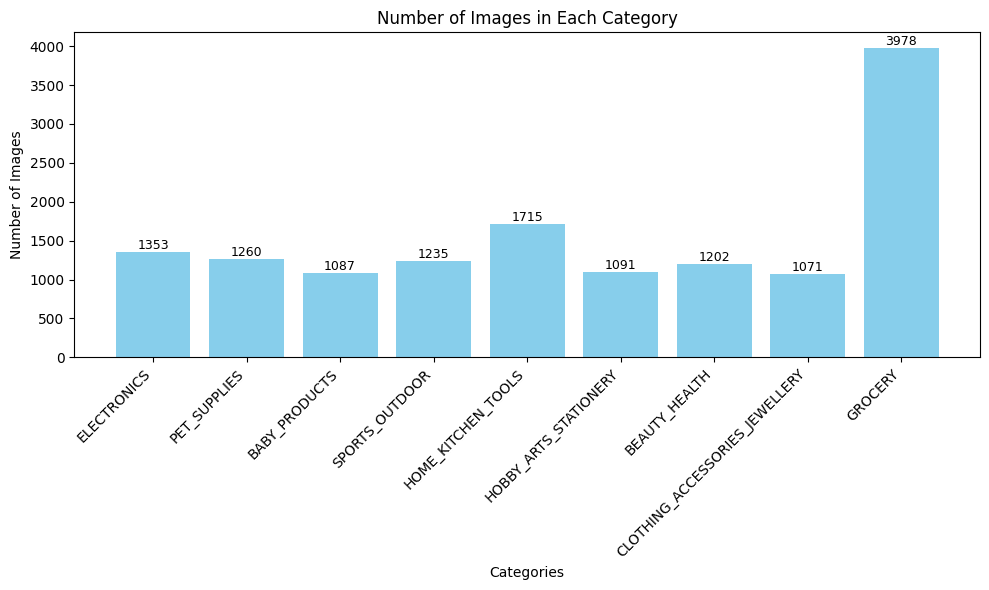

In [49]:
# FINAL_DATA_SET_3
# Main Folder Path
folder_path = "/kaggle/input/final-dataset-all/FINAL_DATASET_3_SPLITTED"

# Sub Folder Paths
train_path = folder_path + '/train'
val_path = folder_path + '/val'
deployment_path = folder_path + '/check'


def get_image_counts(train_path):
    category_counts = {}
    # Loop through each category folder
    for category in os.listdir(train_path):
        category_path = os.path.join(train_path, category)
        # Count the number of image files in the category folder
        image_count = sum([1 for file in os.listdir(category_path) if os.path.isfile(os.path.join(category_path, file))])
        category_counts[category] = image_count
    return category_counts

def plot_image_counts(category_counts):
    categories = list(category_counts.keys())
    counts = list(category_counts.values())
    plt.figure(figsize=(10, 6))
    bars = plt.bar(categories, counts, color='skyblue')
    plt.xlabel('Categories')
    plt.ylabel('Number of Images')
    plt.title('Number of Images in Each Category')
    plt.xticks(rotation=45, ha='right')

    # Add counts on top of each bar
    for bar, count in zip(bars, counts):
        plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), count,
                 ha='center', va='bottom', color='black', fontsize=9)

    plt.tight_layout()
    plt.show()

# Get image counts for each category
category_counts = get_image_counts(train_path)

# Plot image counts as a bar graph
plot_image_counts(category_counts)



In [50]:
# Creating an array of paths
data_paths = [val_path, train_path, deployment_path]
data_labels = ["Validation Data", "Train Data", "Deployment Check Data"]

# Looping over each dataset
for label, path in zip(data_labels, data_paths):
    print(label)
    print(get_image_counts(path))
    print("------------------------------------")

Validation Data
{'ELECTRONICS': 351, 'PET_SUPPLIES': 327, 'BABY_PRODUCTS': 282, 'SPORTS_OUTDOOR': 321, 'HOME_KITCHEN_TOOLS': 445, 'HOBBY_ARTS_STATIONERY': 283, 'BEAUTY_HEALTH': 312, 'CLOTHING_ACCESSORIES_JEWELLERY': 278, 'GROCERY': 1033}
------------------------------------
Train Data
{'ELECTRONICS': 1353, 'PET_SUPPLIES': 1260, 'BABY_PRODUCTS': 1087, 'SPORTS_OUTDOOR': 1235, 'HOME_KITCHEN_TOOLS': 1715, 'HOBBY_ARTS_STATIONERY': 1091, 'BEAUTY_HEALTH': 1202, 'CLOTHING_ACCESSORIES_JEWELLERY': 1071, 'GROCERY': 3978}
------------------------------------
Deployment Check Data
{'ELECTRONICS': 53, 'PET_SUPPLIES': 50, 'BABY_PRODUCTS': 43, 'SPORTS_OUTDOOR': 49, 'HOME_KITCHEN_TOOLS': 68, 'HOBBY_ARTS_STATIONERY': 43, 'BEAUTY_HEALTH': 48, 'CLOTHING_ACCESSORIES_JEWELLERY': 42, 'GROCERY': 155}
------------------------------------


In [24]:

# Eğitim verileri için ImageDataGenerator
image_gen = ImageDataGenerator(rotation_range=15,
                               width_shift_range=0.05,
                               height_shift_range=0.05,
                               rescale=1/255,
                               shear_range=0.05,
                               zoom_range=0.05,
                               horizontal_flip=True,
                               fill_mode="nearest")

# Test verileri için ImageDataGenerator
val_gen = ImageDataGenerator(rescale=1./255)


In [26]:
# Model parameters
epochs = 10
batch_size = 32

In [27]:

# Eğitim verilerini yükleyin ve ön işlemleri yapın
train_generator = image_gen.flow_from_directory(train_path,
                                                target_size=(299,299),
                                                batch_size=batch_size,
                                                class_mode='categorical',
                                               shuffle = True)

# Test verilerini yükleyin ve ön işlemleri yapın
test_generator = val_gen.flow_from_directory(val_path,
                                             target_size=(299,299),
                                             batch_size=batch_size,
                                             class_mode='categorical',
                                             shuffle = False)


Found 8741 images belonging to 9 classes.

Found 3632 images belonging to 9 classes.


# İnception V3

In [28]:
# InceptionV3 modelini yükleyelim (weights='imagenet' ile önceden eğitilmiş ağırlıkları kullanabiliriz)
base_model = InceptionV3(weights='imagenet', include_top=False)

# Mevcut modelin tüm katmanlarını donduralım
for layer in base_model.layers:
    layer.trainable = False

# Mevcut modelin çıktı katmanını alalım
x = base_model.output

# GlobalAveragePooling2D katmanını ekleyelim
x = GlobalAveragePooling2D()(x)

# Dropout katmanını ekleyelim
x = Dropout(0.5)(x)

# Tam bağlı katmanı ekleyelim
x = Dense(1024, activation='relu')(x)

# Bir başka Dropout katmanını ekleyelim
x = Dropout(0.5)(x)

# Son çıktı katmanını ekleyelim (sınıf sayısına göre ayarlanmalıdır)
predictions = Dense(9, activation='softmax')(x)

# Yeni modeli oluşturalım
model = Model(inputs=base_model.input, outputs=predictions)

# Optimizer'ı tanımlayalım
optimizer = RMSprop(learning_rate=1e-5)

# Early Stopping ve Reduce LR on Plateau callback'lerini tanımlayalım
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, min_lr=1e-6)

# Modeli derleyelim
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# Model özetini yazdıralım
model.summary()


87910968/87910968 [==============================] - 0s 0us/step

Model: "model"

__________________________________________________________________________________________________

 Layer (type)                Output Shape                 Param #   Connected to                  


 input_1 (InputLayer)        [(None, None, None, 3)]      0         []                            

                                                                                                  

 conv2d (Conv2D)             (None, None, None, 32)       864       ['input_1[0][0]']             

                                                                                                  

 batch_normalization (Batch  (None, None, None, 32)       96        ['conv2d[0][0]']              

 Normalization)                                                                                   

                                                                                                  

 activation (Act

In [29]:
# Eğitim için epoch sayısı
epochs = 10

# Modeli eğitim verileriyle eğitin
history_inceptionV3 = model.fit(train_generator,
                    epochs=epochs,
                    validation_data=test_generator,
                    callbacks=[early_stopping, reduce_lr])


Epoch 1/10

274/274 [==============================] - 5018s 18s/step - loss: 2.3236 - accuracy: 0.1633 - val_loss: 1.8344 - val_accuracy: 0.3979 - lr: 1.0000e-05

Epoch 2/10

274/274 [==============================] - 247s 903ms/step - loss: 2.0530 - accuracy: 0.2650 - val_loss: 1.6485 - val_accuracy: 0.4920 - lr: 1.0000e-05

Epoch 3/10

274/274 [==============================] - 248s 907ms/step - loss: 1.8982 - accuracy: 0.3252 - val_loss: 1.5365 - val_accuracy: 0.5407 - lr: 1.0000e-05

Epoch 4/10

274/274 [==============================] - 247s 899ms/step - loss: 1.7985 - accuracy: 0.3682 - val_loss: 1.4532 - val_accuracy: 0.5688 - lr: 1.0000e-05

Epoch 5/10

274/274 [==============================] - 246s 897ms/step - loss: 1.7070 - accuracy: 0.4024 - val_loss: 1.3901 - val_accuracy: 0.5843 - lr: 1.0000e-05

Epoch 6/10

274/274 [==============================] - 264s 964ms/step - loss: 1.6680 - accuracy: 0.4172 - val_loss: 1.3444 - val_accuracy: 0.5928 - lr: 1.0000e-05

Epoch 7/10


In [30]:
# Observing the training process
def plot_training_process(history):
    # Extract loss and accuracy from history
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(1, len(acc) + 1)

    # Plot training and validation accuracy
    plt.figure(figsize=(14, 6))

    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, 'bo', label='Training accuracy')
    plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
    plt.title('Training and validation accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # Plot training and validation loss
    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, 'bo', label='Training loss')
    plt.plot(epochs, val_loss, 'b', label='Validation loss')
    plt.title('Training and validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.show()

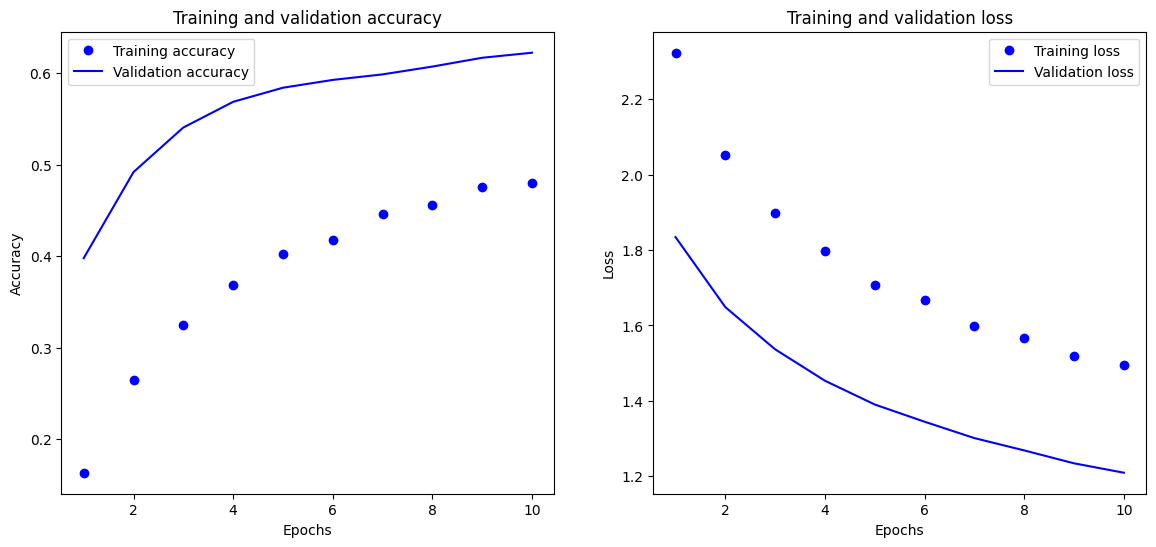

In [33]:
plot_training_process(model.history)

In [31]:
summary = pd.DataFrame(model.history.history)
summary.head()

,loss,accuracy,val_loss,val_accuracy,lr
0,2.323644,0.163254,1.834396,0.397852,0.00001
1,2.053039,0.264958,1.648505,0.492015,0.00001
2,1.898231,0.325249,1.536521,0.540749,0.00001
3,1.798528,0.368150,1.453186,0.568833,0.00001
4,1.706955,0.402357,1.390068,0.584251,0.00001


In [36]:
model.save('InceptionV3_model.h5')

# InceptionV3 with Data Set 3

In [ ]:
# Data augmentation and preprocessing for training
train_image_gen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.10,
    height_shift_range=0.10,
    rescale=1./255,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode="nearest"
)

# Preprocessing for validation
val_image_gen = ImageDataGenerator(rescale=1./255)

# Create data generators
train_generator = train_image_gen.flow_from_directory(
    train_path,
    target_size=(299, 299),  # InceptionV3 requires 299x299 input size
    batch_size=32,
    class_mode='categorical',
    shuffle=True
)

val_generator = val_image_gen.flow_from_directory(
    val_path,
    target_size=(299, 299),  # InceptionV3 requires 299x299 input size
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)

# Load the base model (pre-trained InceptionV3)
base_model_inception = InceptionV3(weights='imagenet', include_top=False, input_shape=(299, 299, 3))

# Freeze the base model layers
base_model_inception.trainable = False

# Add custom layers on top of the base model
model_inception2 = Sequential([
    base_model_inception,
    GlobalAveragePooling2D(),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(9, activation='softmax')
])

# Compile the model
model_inception2.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

# Model summary
model_inception2.summary()

# Unfreeze the top layers of the base model
for layer in base_model_inception.layers[-4:]:
    layer.trainable = True

# Recompile the model with a lower learning rate
model_inception2.compile(optimizer=RMSprop(learning_rate=1e-5),
                   loss='categorical_crossentropy',
                   metrics=['accuracy'])

# Set up callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, min_lr=1e-6)

callbacks = [early_stopping, reduce_lr]

# Train the model again with the unfrozen layers
history_inception = model_inception2.fit(
    train_generator,
    validation_data=val_generator,
    epochs=25,
    callbacks=callbacks
)


Found 13992 images belonging to 9 classes.
Found 3632 images belonging to 9 classes.
87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ inception_v3 (Functional)       │ ?                      │    21,802,784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ ?                      │   0 (unbuilt) │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 21,802,784 (83.17 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 21,802,784 (83.17 MB)

Epoch 1/25
  2/438 ━━━━━━━━━━━━━━━━━━━━ 33s 77ms/step - accuracy: 0.0938 - loss: 2.4929   

I0000 00:00:1716490807.836819     167 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
W0000 00:00:1716490807.892992     167 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


438/438 ━━━━━━━━━━━━━━━━━━━━ 0s 737ms/step - accuracy: 0.2052 - loss: 2.2153

W0000 00:00:1716491136.287703     168 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


438/438 ━━━━━━━━━━━━━━━━━━━━ 391s 826ms/step - accuracy: 0.2053 - loss: 2.2151 - val_accuracy: 0.3659 - val_loss: 1.8130 - learning_rate: 1.0000e-05
Epoch 2/25
438/438 ━━━━━━━━━━━━━━━━━━━━ 280s 629ms/step - accuracy: 0.3385 - loss: 1.9042 - val_accuracy: 0.4705 - val_loss: 1.6698 - learning_rate: 1.0000e-05
Epoch 3/25
438/438 ━━━━━━━━━━━━━━━━━━━━ 281s 631ms/step - accuracy: 0.3971 - loss: 1.7730 - val_accuracy: 0.5094 - val_loss: 1.5712 - learning_rate: 1.0000e-05
Epoch 4/25
438/438 ━━━━━━━━━━━━━━━━━━━━ 282s 634ms/step - accuracy: 0.4279 - loss: 1.6747 - val_accuracy: 0.5402 - val_loss: 1.4890 - learning_rate: 1.0000e-05
Epoch 5/25
438/438 ━━━━━━━━━━━━━━━━━━━━ 280s 631ms/step - accuracy: 0.4461 - loss: 1.6232 - val_accuracy: 0.5562 - val_loss: 1.4211 - learning_rate: 1.0000e-05
Epoch 6/25
438/438 ━━━━━━━━━━━━━━━━━━━━ 283s 637ms/step - accuracy: 0.4680 - loss: 1.5806 - val_accuracy: 0.5782 - val_loss: 1.3705 - learning_rate: 1.0000e-05
Epoch 7/25
438/438 ━━━━━━━━━━━━━━━━━━━━ 286s 643ms/

# Mobile Net with Data Set 1

In [54]:
# Paths to your datasets on Kaggle
folder_path = '/kaggle/input/category-prediction-for-e-commerce-images-dataset/FINAL_DATASET_SPLITTED'
train_path = os.path.join(folder_path, 'train')
val_path = os.path.join(folder_path, 'val')
check_path = os.path.join(folder_path, 'check')

In [55]:
image_gen = ImageDataGenerator(rotation_range=15,
                               width_shift_range=0.05,
                               height_shift_range=0.05,
                               rescale=1/255,
                               shear_range=0.05,
                               zoom_range=0.05,
                               horizontal_flip=True,
                               fill_mode="nearest")

val_gen = ImageDataGenerator(rescale=1./255)

In [56]:
# Model parameters
img_size = (224, 224)
num_classes = 9
epochs = 25
batch_size = 32

In [57]:
# Training and validation data generators
train_image_gen = image_gen.flow_from_directory(train_path,
                                                target_size=(224, 224),
                                                color_mode="rgb",
                                                batch_size=batch_size,
                                                class_mode="categorical",
                                                shuffle=True)

val_image_gen = val_gen.flow_from_directory(val_path,
                                            target_size=(224, 224),
                                            batch_size=batch_size,
                                            class_mode='categorical',
                                           shuffle = False)

Found 11330 images belonging to 9 classes.
Found 3029 images belonging to 9 classes.


In [58]:
# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, min_lr=1e-5)

callbacks = [early_stopping, reduce_lr]

In [59]:
# Load MobileNetV2 base model (without top layers) and manually specify weights path
base_model = MobileNetV2(input_shape=(224, 224, 3), include_top=False, weights="imagenet")


# Add custom layers on top of the base model
model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(1024, activation='relu'),
    Dropout(0.5),
    Dense(256, activation='relu'),
    Dense(9, activation='softmax')
])


In [60]:
# Compile the model
model.compile(optimizer=Adam(learning_rate=1e-5), loss='categorical_crossentropy', metrics=['accuracy'])



In [61]:
# Train the model
history = model.fit(train_image_gen,
                    steps_per_epoch=train_image_gen.samples // batch_size,
                    validation_data=val_image_gen,
                    validation_steps=val_image_gen.samples // batch_size,
                    epochs=epochs,
                    callbacks=callbacks)

Epoch 1/25
354/354 ━━━━━━━━━━━━━━━━━━━━ 241s 508ms/step - accuracy: 0.2887 - loss: 2.0679 - val_accuracy: 0.4877 - val_loss: 1.5513 - learning_rate: 1.0000e-05
Epoch 2/25
354/354 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.4375 - loss: 1.5594 - val_accuracy: 0.0000e+00 - val_loss: 2.5283 - learning_rate: 1.0000e-05
Epoch 3/25
354/354 ━━━━━━━━━━━━━━━━━━━━ 157s 436ms/step - accuracy: 0.4788 - loss: 1.5621 - val_accuracy: 0.5685 - val_loss: 1.3162 - learning_rate: 1.0000e-05
Epoch 4/25
354/354 ━━━━━━━━━━━━━━━━━━━━ 0s 150us/step - accuracy: 0.4688 - loss: 1.4482 - val_accuracy: 0.0476 - val_loss: 2.3034 - learning_rate: 1.0000e-05
Epoch 5/25
354/354 ━━━━━━━━━━━━━━━━━━━━ 159s 440ms/step - accuracy: 0.5629 - loss: 1.3241 - val_accuracy: 0.6137 - val_loss: 1.1526 - learning_rate: 1.0000e-05
Epoch 6/25
354/354 ━━━━━━━━━━━━━━━━━━━━ 0s 167us/step - accuracy: 0.7188 - loss: 1.0447 - val_accuracy: 0.2381 - val_loss: 1.9536 - learning_rate: 1.0000e-05
Epoch 7/25
354/354 ━━━━━━━━━━━━━━━━━━━━ 159s

In [62]:
# Observing the training process
def plot_training_process(history):
    # Extract loss and accuracy from history
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(1, len(acc) + 1)

    # Plot training and validation accuracy
    plt.figure(figsize=(14, 6))

    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, 'bo', label='Training accuracy')
    plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
    plt.title('Training and validation accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # Plot training and validation loss
    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, 'bo', label='Training loss')
    plt.plot(epochs, val_loss, 'b', label='Validation loss')
    plt.title('Training and validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.show()

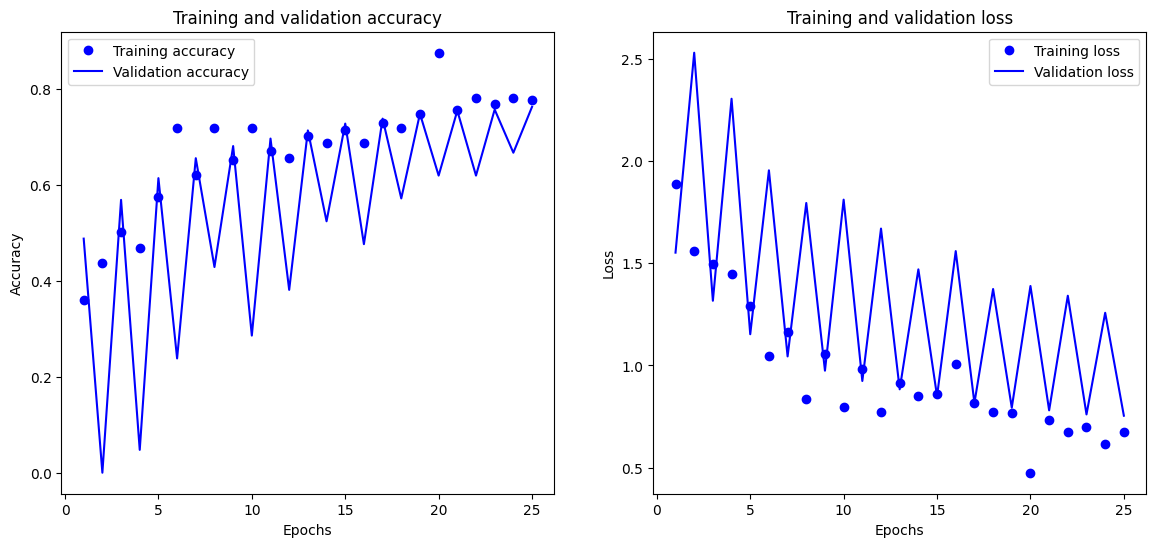

In [63]:
plot_training_process(history)

# Mobil Net with Data Set 

In [69]:
# Paths datasets on Kaggle
folder_path = '/kaggle/input/category-prediction-for-e-commerce-images-dataset/FINAL_DATASET_SPLITTED'
train_path = os.path.join(folder_path, 'train')
val_path = os.path.join(folder_path, 'val')
check_path = os.path.join(folder_path, 'check')

image_gen = ImageDataGenerator(rotation_range=30,
                               width_shift_range=0.3,
                               height_shift_range=0.3,
                               rescale=1/255,
                               shear_range=0.1,
                               zoom_range=0.2,
                               horizontal_flip=True,
                               fill_mode="nearest")

val_gen = ImageDataGenerator(rescale=1./255)

# Training and validation data generators
train_image_gen = image_gen.flow_from_directory(train_path,
                                                target_size=(224, 224),
                                                color_mode="rgb",
                                                batch_size= 32,
                                                class_mode="categorical",
                                                shuffle=True)

val_image_gen = val_gen.flow_from_directory(val_path,
                                            target_size=(224, 224),
                                            batch_size= 32,
                                            class_mode='categorical',
                                           shuffle = False)


# Load MobileNetV2 base model (without top layers) and manually specify weights path

base_model = MobileNetV2(input_shape=(224, 224, 3), include_top=False, weights="imagenet")


# Add custom layers on top of the base model
model_tune = Sequential([
    base_model,
    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(9, activation='softmax')
])

Found 11330 images belonging to 9 classes.
Found 3029 images belonging to 9 classes.


In [71]:
from tensorflow.keras.optimizers import RMSprop
# Unfreeze the top layers of the base model
for layer in base_model.layers[-4:]:
    layer.trainable = True


# Recompile the model with a lower learning rate
model_tune.compile(optimizer = RMSprop(learning_rate=1e-5),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, min_lr=1e-7)

callbacks = [early_stopping, reduce_lr]

# Train the model again with the unfrozen layers
history_fine_tune = model_tune.fit(
    train_image_gen,
    validation_data=val_image_gen,
    epochs=20,
    callbacks=callbacks
)

Epoch 1/20
 16/355 ━━━━━━━━━━━━━━━━━━━━ 9:15 2s/step - accuracy: 0.5303 - loss: 1.3487  

W0000 00:00:1716560061.028507     222 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


355/355 ━━━━━━━━━━━━━━━━━━━━ 236s 534ms/step - accuracy: 0.5453 - loss: 1.4071 - val_accuracy: 0.5959 - val_loss: 1.3397 - learning_rate: 1.0000e-05
Epoch 2/20
355/355 ━━━━━━━━━━━━━━━━━━━━ 171s 471ms/step - accuracy: 0.5677 - loss: 1.3250 - val_accuracy: 0.5969 - val_loss: 1.4449 - learning_rate: 1.0000e-05
Epoch 3/20
355/355 ━━━━━━━━━━━━━━━━━━━━ 170s 468ms/step - accuracy: 0.5862 - loss: 1.2689 - val_accuracy: 0.6276 - val_loss: 1.3528 - learning_rate: 1.0000e-05
Epoch 4/20
355/355 ━━━━━━━━━━━━━━━━━━━━ 169s 466ms/step - accuracy: 0.6111 - loss: 1.1866 - val_accuracy: 0.6157 - val_loss: 1.5321 - learning_rate: 1.0000e-05
Epoch 5/20
355/355 ━━━━━━━━━━━━━━━━━━━━ 169s 468ms/step - accuracy: 0.6250 - loss: 1.1428 - val_accuracy: 0.6444 - val_loss: 1.2778 - learning_rate: 1.0000e-06
Epoch 6/20
355/355 ━━━━━━━━━━━━━━━━━━━━ 169s 467ms/step - accuracy: 0.6372 - loss: 1.1290 - val_accuracy: 0.6642 - val_loss: 1.1357 - learning_rate: 1.0000e-06
Epoch 7/20
355/355 ━━━━━━━━━━━━━━━━━━━━ 168s 464ms/

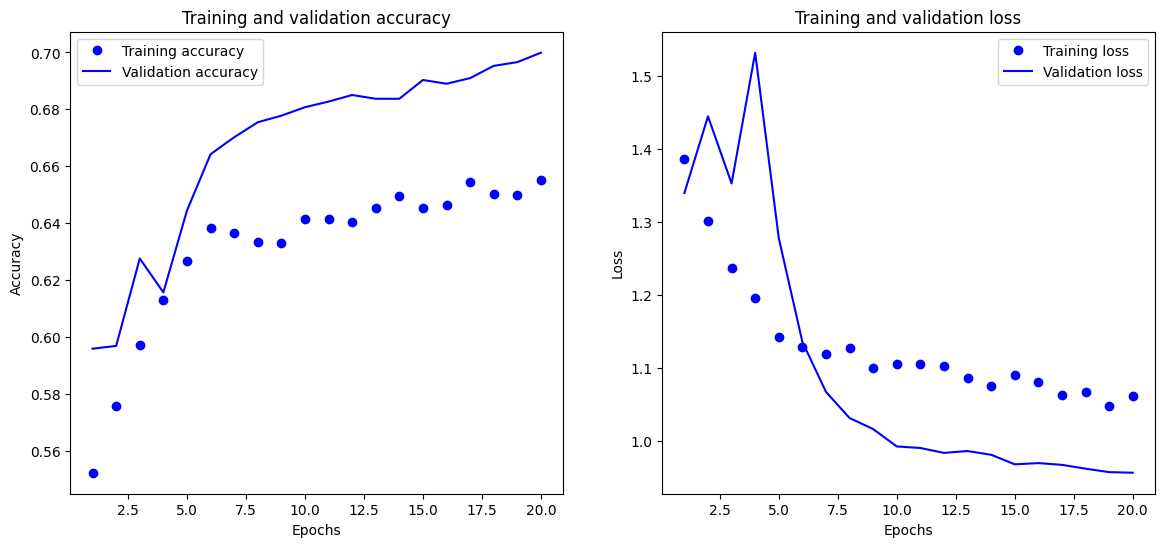

In [72]:
plot_training_process(history_fine_tune)

In [5]:
# model_tune.save('mobile_model2.h5')

In [74]:
# Train the model again with the unfrozen layers
history_fine_tune = model_tune.fit(
    train_image_gen,
    validation_data=val_image_gen,
    epochs=10,
    callbacks=callbacks
)

Epoch 1/50
355/355 ━━━━━━━━━━━━━━━━━━━━ 187s 518ms/step - accuracy: 0.6507 - loss: 1.0438 - val_accuracy: 0.6979 - val_loss: 0.9562 - learning_rate: 1.0000e-06
Epoch 2/50
355/355 ━━━━━━━━━━━━━━━━━━━━ 172s 475ms/step - accuracy: 0.6502 - loss: 1.0701 - val_accuracy: 0.6956 - val_loss: 0.9636 - learning_rate: 1.0000e-06
Epoch 3/50
355/355 ━━━━━━━━━━━━━━━━━━━━ 169s 467ms/step - accuracy: 0.6578 - loss: 1.0497 - val_accuracy: 0.6973 - val_loss: 0.9595 - learning_rate: 1.0000e-06
Epoch 4/50
355/355 ━━━━━━━━━━━━━━━━━━━━ 166s 458ms/step - accuracy: 0.6573 - loss: 1.0428 - val_accuracy: 0.7032 - val_loss: 0.9464 - learning_rate: 1.0000e-06
Epoch 5/50
355/355 ━━━━━━━━━━━━━━━━━━━━ 164s 453ms/step - accuracy: 0.6570 - loss: 1.0603 - val_accuracy: 0.7006 - val_loss: 0.9511 - learning_rate: 1.0000e-06
Epoch 6/50
355/355 ━━━━━━━━━━━━━━━━━━━━ 162s 448ms/step - accuracy: 0.6594 - loss: 1.0580 - val_accuracy: 0.7006 - val_loss: 0.9531 - learning_rate: 1.0000e-06
Epoch 7/50
355/355 ━━━━━━━━━━━━━━━━━━━━ 

KeyboardInterrupt: 

# InceptionV3 Data Set 1

In [75]:
# Data augmentation and preprocessing for training
train_image_gen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.10,
    height_shift_range=0.10,
    rescale=1./255,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode="nearest"
)

# Preprocessing for validation
val_image_gen = ImageDataGenerator(rescale=1./255)

# Create data generators
train_generator = train_image_gen.flow_from_directory(
    train_path,
    target_size=(299, 299),
    batch_size=32,
    class_mode='categorical',
    shuffle=True
)

val_generator = val_image_gen.flow_from_directory(
    val_path,
    target_size=(299, 299),
    batch_size=32,
    class_mode='categorical',
    shuffle = False
)


Found 11330 images belonging to 9 classes.
Found 3029 images belonging to 9 classes.


In [76]:
# Load InceptionV3 base model (without top layers) and manually specify weights path
base_model = InceptionV3(input_shape=(299, 299, 3), include_top=False, weights="imagenet")

# Add custom layers on top of the base model
model_inception = Sequential([
    base_model,
    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(9, activation='softmax')
])

In [77]:
# Unfreeze the top layers of the base model
for layer in base_model.layers[-4:]:
    layer.trainable = True

# Recompile the model with a lower learning rate
model_inception.compile(optimizer=RMSprop(learning_rate=1e-5),
                   loss='categorical_crossentropy',
                   metrics=['accuracy'])

In [ ]:
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, min_lr=1e-6)

callbacks = [early_stopping, reduce_lr]

In [ ]:
# Train the model again with the unfrozen layers
history_inception = model_inception.fit(
    train_generator,
    validation_data=val_generator,
    epochs=10,
    callbacks=callbacks
)

Epoch 1/10


W0000 00:00:1716305717.731620     127 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


155/355 ━━━━━━━━━━━━━━━━━━━━ 3:41 1s/step - accuracy: 0.3533 - loss: 2.1087   

W0000 00:00:1716305888.891975     126 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


355/355 ━━━━━━━━━━━━━━━━━━━━ 0s 917ms/step - accuracy: 0.4244 - loss: 1.8260

W0000 00:00:1716306050.466383     126 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update

W0000 00:00:1716306082.910942     127 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


355/355 ━━━━━━━━━━━━━━━━━━━━ 495s 1s/step - accuracy: 0.4247 - loss: 1.8251 - val_accuracy: 0.6794 - val_loss: 0.9945 - learning_rate: 1.0000e-05

Epoch 2/10

355/355 ━━━━━━━━━━━━━━━━━━━━ 295s 815ms/step - accuracy: 0.6402 - loss: 1.1044 - val_accuracy: 0.7227 - val_loss: 0.8784 - learning_rate: 1.0000e-05

Epoch 3/10

355/355 ━━━━━━━━━━━━━━━━━━━━ 297s 821ms/step - accuracy: 0.7042 - loss: 0.9038 - val_accuracy: 0.7583 - val_loss: 0.7852 - learning_rate: 1.0000e-05

Epoch 4/10

355/355 ━━━━━━━━━━━━━━━━━━━━ 301s 832ms/step - accuracy: 0.7465 - loss: 0.7832 - val_accuracy: 0.7735 - val_loss: 0.7568 - learning_rate: 1.0000e-05

Epoch 5/10

355/355 ━━━━━━━━━━━━━━━━━━━━ 300s 828ms/step - accuracy: 0.7866 - loss: 0.6758 - val_accuracy: 0.7864 - val_loss: 0.7325 - learning_rate: 1.0000e-05

Epoch 6/10

355/355 ━━━━━━━━━━━━━━━━━━━━ 298s 824ms/step - accuracy: 0.8071 - loss: 0.5924 - val_accuracy: 0.7745 - val_loss: 0.8894 - learning_rate: 1.0000e-05

Epoch 7/10

355/355 ━━━━━━━━━━━━━━━━━━━━ 29

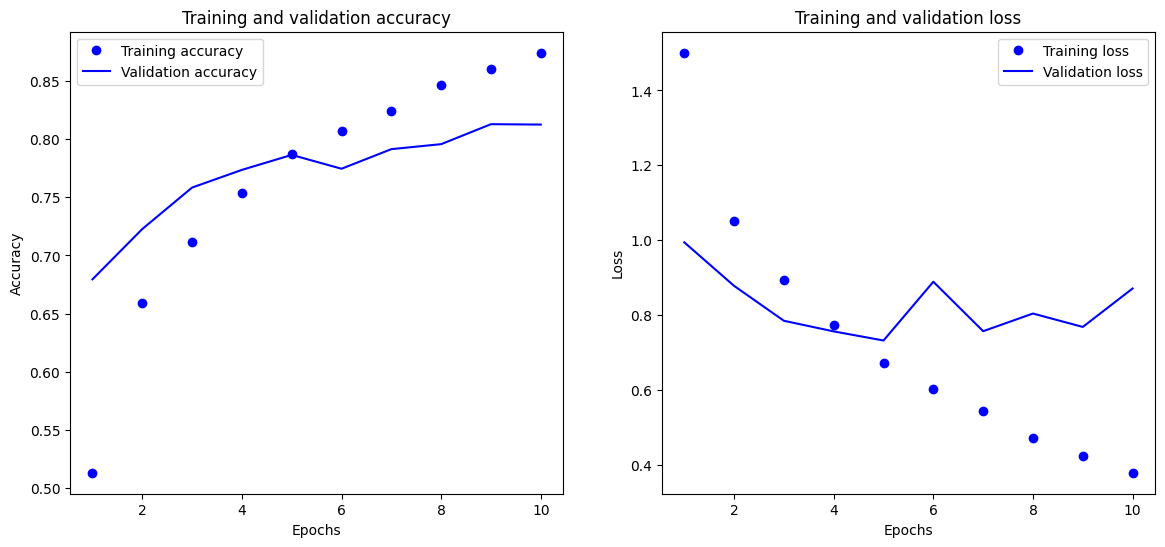

In [ ]:
plot_training_process(history_inception)

In [4]:
# Var olan bir dosyanın üzerine yazmak için
# model_inception.save('InceptionV3_model.h5')



# InceptionV3 Tuning

In [79]:
# Add custom layers on top of the base model
model_inception_tuning = Sequential([
    base_model,
    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(9, activation='softmax')
])

In [85]:
# Unfreeze the top layers of the base model
for layer in base_model.layers[-6:]:
    layer.trainable = True

# Recompile the model with a lower learning rate
model_inception_tuning.compile(optimizer=RMSprop(learning_rate=1e-5),
                   loss='categorical_crossentropy',
                   metrics=['accuracy'])

In [83]:
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, min_lr=1e-7)

callbacks = [early_stopping, reduce_lr]

In [87]:
# Train the model again with the unfrozen layers
history_inception = model_inception_tuning.fit(
    train_generator,
    validation_data=val_generator,
    epochs=25,
    callbacks=callbacks
)

Epoch 1/25
355/355 ━━━━━━━━━━━━━━━━━━━━ 308s 852ms/step - accuracy: 0.5095 - loss: 1.4819 - val_accuracy: 0.6474 - val_loss: 1.1836 - learning_rate: 1.0000e-05
Epoch 2/25
355/355 ━━━━━━━━━━━━━━━━━━━━ 309s 855ms/step - accuracy: 0.5492 - loss: 1.3517 - val_accuracy: 0.6850 - val_loss: 1.0343 - learning_rate: 1.0000e-05
Epoch 3/25
355/355 ━━━━━━━━━━━━━━━━━━━━ 314s 867ms/step - accuracy: 0.6097 - loss: 1.2049 - val_accuracy: 0.7131 - val_loss: 1.0137 - learning_rate: 1.0000e-05
Epoch 4/25
355/355 ━━━━━━━━━━━━━━━━━━━━ 313s 865ms/step - accuracy: 0.6414 - loss: 1.1164 - val_accuracy: 0.7372 - val_loss: 0.9012 - learning_rate: 1.0000e-05
Epoch 5/25
355/355 ━━━━━━━━━━━━━━━━━━━━ 316s 873ms/step - accuracy: 0.6600 - loss: 1.0672 - val_accuracy: 0.7547 - val_loss: 0.8704 - learning_rate: 1.0000e-05
Epoch 6/25
355/355 ━━━━━━━━━━━━━━━━━━━━ 311s 858ms/step - accuracy: 0.6842 - loss: 1.0067 - val_accuracy: 0.7633 - val_loss: 0.8544 - learning_rate: 1.0000e-05
Epoch 7/25
355/355 ━━━━━━━━━━━━━━━━━━━━ 

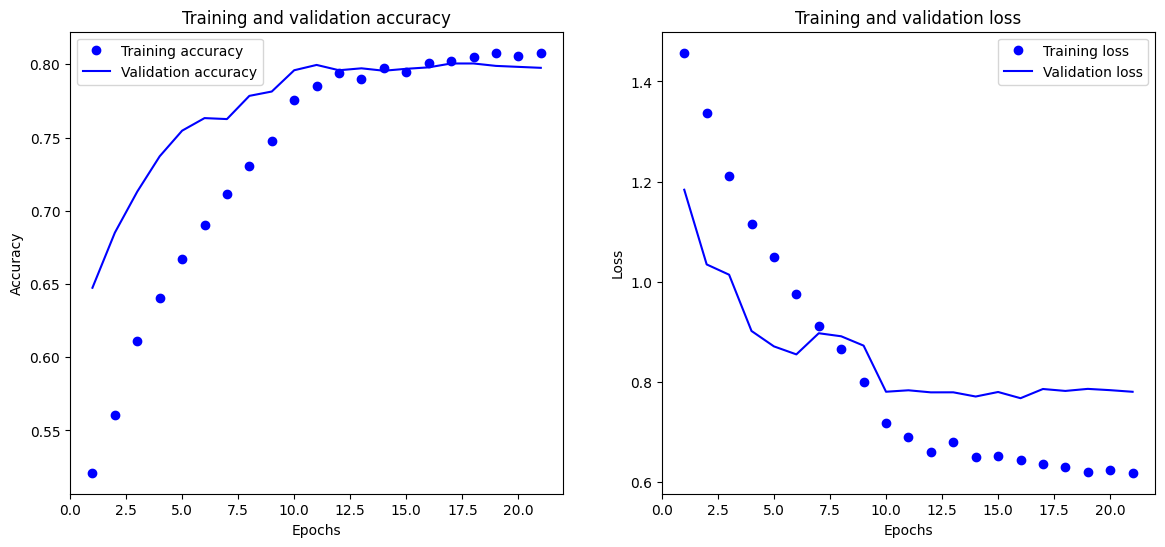

In [88]:
plot_training_process(history_inception)

In [3]:
# Var olan bir dosyanın üzerine yazmak için
# model_inception_tuning.save('InceptionV3_model_tuning_last.h5')

# InceptionV3 with Data Set 1

In [3]:
folder_path = "/kaggle/input/category-prediction-for-e-commerce-images-dataset/FINAL_DATASET_SPLITTED"
train_path = os.path.join(folder_path, 'train')
val_path = os.path.join(folder_path, 'val')

In [5]:
# Data augmentation and preprocessing for training
train_image_gen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.10,
    height_shift_range=0.10,
    rescale=1./255,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode="nearest"
)

# Preprocessing for validation
val_image_gen = ImageDataGenerator(rescale=1./255)

# Create data generators
train_generator = train_image_gen.flow_from_directory(
    train_path,
    target_size=(299, 299),
    batch_size=32,
    class_mode='categorical',
    shuffle=True
)

val_generator = val_image_gen.flow_from_directory(
    val_path,
    target_size=(299, 299),
    batch_size=32,
    class_mode='categorical',
    shuffle = False
)


Found 11330 images belonging to 9 classes.
Found 3029 images belonging to 9 classes.


In [7]:
# Load InceptionV3 base model (without top layers)
base_model = InceptionV3(input_shape=(299, 299, 3), include_top=False, weights="imagenet")

# Add custom layers on top of the base model
model_inception = Sequential([
    base_model,
    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(9, activation='softmax')
])

# Unfreeze the top layers of the base model
for layer in base_model.layers[-4:]:
    layer.trainable = True

# Recompile the model with a lower learning rate
model_inception.compile(optimizer=RMSprop(learning_rate=1e-5),
                        loss='categorical_crossentropy',
                        metrics=['accuracy'])

# Define callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, min_lr=1e-6)

callbacks = [early_stopping, reduce_lr]

# Assuming train_generator and val_generator are defined elsewhere and properly
# Train the model again with the unfrozen layers
history_inception = model_inception.fit(
    train_generator,
    validation_data=val_generator,
    epochs=25,
    callbacks=callbacks
)


Epoch 1/25
 36/355 ━━━━━━━━━━━━━━━━━━━━ 8:15 2s/step - accuracy: 0.2818 - loss: 2.7090   

W0000 00:00:1716542717.345004     223 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


355/355 ━━━━━━━━━━━━━━━━━━━━ 363s 823ms/step - accuracy: 0.4381 - loss: 1.8176 - val_accuracy: 0.6821 - val_loss: 0.9818 - learning_rate: 1.0000e-05
Epoch 2/25
355/355 ━━━━━━━━━━━━━━━━━━━━ 270s 747ms/step - accuracy: 0.6415 - loss: 1.0901 - val_accuracy: 0.7078 - val_loss: 0.9306 - learning_rate: 1.0000e-05
Epoch 3/25
355/355 ━━━━━━━━━━━━━━━━━━━━ 268s 741ms/step - accuracy: 0.7091 - loss: 0.8792 - val_accuracy: 0.7544 - val_loss: 0.8333 - learning_rate: 1.0000e-05
Epoch 4/25
355/355 ━━━━━━━━━━━━━━━━━━━━ 265s 732ms/step - accuracy: 0.7506 - loss: 0.7932 - val_accuracy: 0.7689 - val_loss: 0.7331 - learning_rate: 1.0000e-05
Epoch 5/25
355/355 ━━━━━━━━━━━━━━━━━━━━ 262s 724ms/step - accuracy: 0.7705 - loss: 0.6997 - val_accuracy: 0.7814 - val_loss: 0.7511 - learning_rate: 1.0000e-05
Epoch 6/25
355/355 ━━━━━━━━━━━━━━━━━━━━ 263s 726ms/step - accuracy: 0.8048 - loss: 0.5927 - val_accuracy: 0.7930 - val_loss: 0.7455 - learning_rate: 1.0000e-05
Epoch 7/25
355/355 ━━━━━━━━━━━━━━━━━━━━ 262s 725ms/

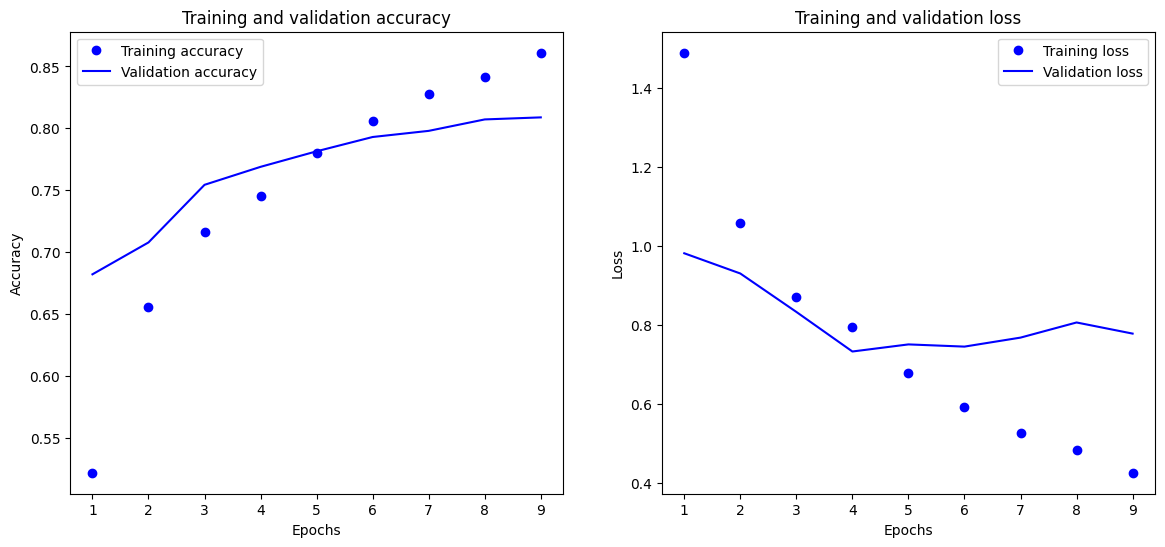

In [8]:
# Observing the training process
def plot_training_process(history):
    # Extract loss and accuracy from history
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(1, len(acc) + 1)

    # Plot training and validation accuracy
    plt.figure(figsize=(14, 6))

    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, 'bo', label='Training accuracy')
    plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
    plt.title('Training and validation accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # Plot training and validation loss
    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, 'bo', label='Training loss')
    plt.plot(epochs, val_loss, 'b', label='Validation loss')
    plt.title('Training and validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.show()
    
plot_training_process(model_inception.history)

In [2]:
# Var olan bir dosyanın üzerine yazmak için
# model_inception.save('model_inception_data1.h5')

## 3. Data Set

In [10]:
# Paths to your datasets on Kaggle
folder_path = '/kaggle/input/final-dataset-all/FINAL_DATASET_3_SPLITTED'
train_path = os.path.join(folder_path, 'train')
val_path = os.path.join(folder_path, 'val')
check_path = os.path.join(folder_path, 'check')

In [11]:
# Data augmentation and preprocessing for training
train_image_gen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.10,
    height_shift_range=0.10,
    rescale=1./255,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode="nearest"
)

# Preprocessing for validation
val_image_gen = ImageDataGenerator(rescale=1./255)

# Create data generators
train_generator = train_image_gen.flow_from_directory(
    train_path,
    target_size=(299, 299),
    batch_size=32,
    class_mode='categorical',
    shuffle=True
)

val_generator = val_image_gen.flow_from_directory(
    val_path,
    target_size=(299, 299),
    batch_size=32,
    class_mode='categorical',
    shuffle = False
)


Found 13992 images belonging to 9 classes.
Found 3632 images belonging to 9 classes.


In [15]:
base_model = InceptionV3(input_shape=(299, 299, 3), include_top=False, weights="imagenet")

# Add custom layers on top of the base model
model_inception_data3 = Sequential([
    base_model,
    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(9, activation='softmax')
])

In [16]:
# Unfreeze the top layers of the base model
for layer in base_model.layers[-4:]:
    layer.trainable = True

# Recompile the model with a lower learning rate
model_inception_data3.compile(optimizer=RMSprop(learning_rate=1e-5),
                   loss='categorical_crossentropy',
                   metrics=['accuracy'])

In [14]:
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, min_lr=1e-6)

callbacks = [early_stopping, reduce_lr]

In [18]:
# Train the model again with the unfrozen layers
history_inception = model_inception_data3.fit(
    train_generator,
    validation_data=val_generator,
    epochs=25,
    callbacks=callbacks
)

Epoch 1/25
438/438 ━━━━━━━━━━━━━━━━━━━━ 328s 739ms/step - accuracy: 0.6561 - loss: 1.0699 - val_accuracy: 0.7349 - val_loss: 0.8102 - learning_rate: 1.0000e-05
Epoch 2/25
438/438 ━━━━━━━━━━━━━━━━━━━━ 334s 751ms/step - accuracy: 0.7100 - loss: 0.8954 - val_accuracy: 0.7610 - val_loss: 0.7594 - learning_rate: 1.0000e-05
Epoch 3/25
438/438 ━━━━━━━━━━━━━━━━━━━━ 346s 777ms/step - accuracy: 0.7550 - loss: 0.7612 - val_accuracy: 0.7773 - val_loss: 0.7815 - learning_rate: 1.0000e-05
Epoch 4/25
438/438 ━━━━━━━━━━━━━━━━━━━━ 348s 782ms/step - accuracy: 0.7812 - loss: 0.6760 - val_accuracy: 0.7839 - val_loss: 0.7325 - learning_rate: 1.0000e-05
Epoch 5/25
438/438 ━━━━━━━━━━━━━━━━━━━━ 344s 772ms/step - accuracy: 0.8064 - loss: 0.6107 - val_accuracy: 0.7894 - val_loss: 0.7120 - learning_rate: 1.0000e-05
Epoch 6/25
438/438 ━━━━━━━━━━━━━━━━━━━━ 347s 779ms/step - accuracy: 0.8277 - loss: 0.5314 - val_accuracy: 0.8048 - val_loss: 0.7441 - learning_rate: 1.0000e-05
Epoch 7/25
438/438 ━━━━━━━━━━━━━━━━━━━━ 

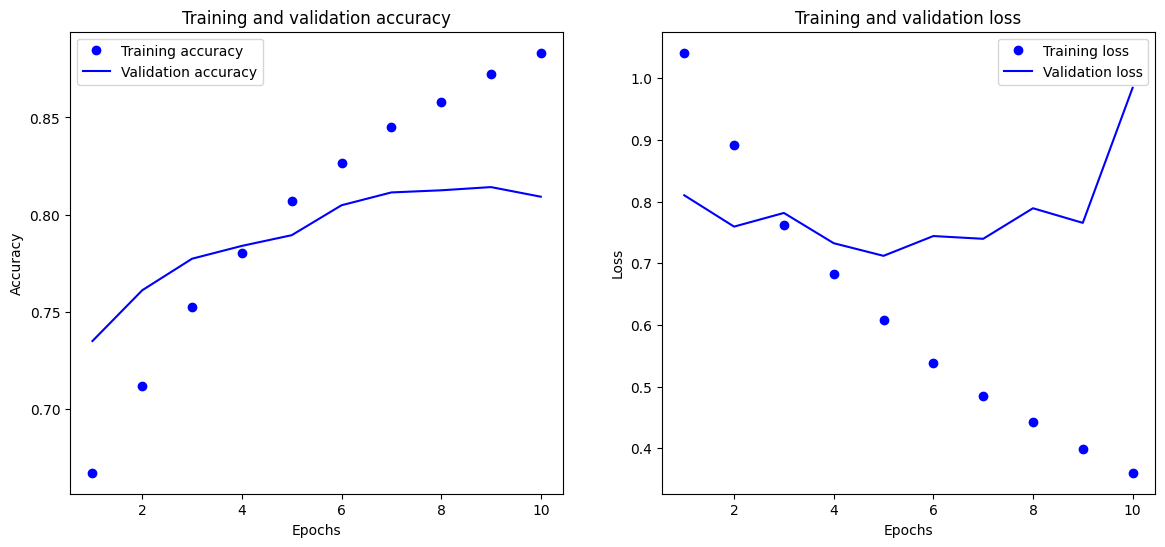

In [19]:
plot_training_process(history_inception)

In [1]:
# Save the model
# model_inception_data3.save('InceptionV3_model_data3.h5')

# Final Model

In [2]:
base_dir = '/kaggle/input/final-dataset-all/FINAL_DATASET_3_SPLITTED'
train_dir = os.path.join(base_dir, 'train')
val_dir = os.path.join(base_dir, 'val')
check_dir = os.path.join(base_dir, 'check')

In [3]:
# Define data augmentation techniques
datagen = ImageDataGenerator(
    rescale=1./255,
    horizontal_flip=True,
    zoom_range=0.2,
    shear_range = 0.2
)

# Example of using the generator
train_generator = datagen.flow_from_directory(
    train_dir,
    color_mode = 'rgb',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle = True
)

Found 13992 images belonging to 9 classes.


In [4]:
# Get category labels from the generator
labels = train_generator.class_indices

# Print labels
print("Category Labels:")
for category, label in labels.items():
    print(f"{category}: {label}")

Category Labels:
BABY_PRODUCTS: 0
BEAUTY_HEALTH: 1
CLOTHING_ACCESSORIES_JEWELLERY: 2
ELECTRONICS: 3
GROCERY: 4
HOBBY_ARTS_STATIONERY: 5
HOME_KITCHEN_TOOLS: 6
PET_SUPPLIES: 7
SPORTS_OUTDOOR: 8


In [5]:
# Define validation data generator without augmentation
val_datagen = ImageDataGenerator(rescale=1./255)

# Example of using the generator for the validation set
val_generator = val_datagen.flow_from_directory(
    val_dir,
    color_mode = 'rgb',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle= False
)

Found 3632 images belonging to 9 classes.


In [6]:
# Parameters
img_size = (224, 224)
batch_size = 32
num_classes = 9
epochs = 25

# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, min_lr=1e-6)

callbacks = [early_stopping, reduce_lr]


In [7]:
# Define different optimizers
optimizers = {
    'SGD': SGD(learning_rate=1e-3, momentum=0.9, nesterov=True),
    'RMSprop': RMSprop(learning_rate=1e-4),
    'Adam': Adam(learning_rate=1e-4),
    'AdamW': tf.keras.optimizers.AdamW(learning_rate=1e-4, weight_decay=1e-5),
    'Adagrad': Adagrad(learning_rate=1e-4),
    'Adadelta': Adadelta(learning_rate=1e-4),
    'Adamax': tf.keras.optimizers.Adamax(learning_rate=1e-4),
    'Nadam': tf.keras.optimizers.Nadam(learning_rate=1e-4)
}

In [8]:
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(*img_size, 3))

# Add out top layers
x = base_model.output
x = Flatten()(x)
x = Dense(512, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
x = Dense(256, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.25)(x)

predictions = Dense(num_classes, activation='softmax')(x)

# Combine the base layer and our top layers
model = Model(inputs=base_model.input, outputs=predictions)

# Freeze the base model layers
for layer in base_model.layers:
    layer.trainable = False
    
# Choose the optimizer from optimizers dictionary
optimizer_ = optimizers['Adam']

# Compile the model
model.compile(optimizer=optimizer_, loss='categorical_crossentropy', metrics=['accuracy'])

print("Model compiled and ready for training.")

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
Model compiled and ready for training.


In [9]:
history = model.fit(
    train_generator,
    epochs=epochs,
    validation_data=val_generator,
    callbacks=callbacks
)

print("Training complete.")

Epoch 1/25
  1/438 ━━━━━━━━━━━━━━━━━━━━ 2:19:36 19s/step - accuracy: 0.1562 - loss: 2.6577

I0000 00:00:1717763730.708497      99 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


 93/438 ━━━━━━━━━━━━━━━━━━━━ 2:58 518ms/step - accuracy: 0.3694 - loss: 2.1152

W0000 00:00:1717763778.380397      97 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


438/438 ━━━━━━━━━━━━━━━━━━━━ 246s 518ms/step - accuracy: 0.4954 - loss: 1.6677 - val_accuracy: 0.7296 - val_loss: 0.8626 - learning_rate: 1.0000e-04
Epoch 2/25
438/438 ━━━━━━━━━━━━━━━━━━━━ 164s 368ms/step - accuracy: 0.6787 - loss: 1.0032 - val_accuracy: 0.7544 - val_loss: 0.7714 - learning_rate: 1.0000e-04
Epoch 3/25
438/438 ━━━━━━━━━━━━━━━━━━━━ 163s 367ms/step - accuracy: 0.7398 - loss: 0.8060 - val_accuracy: 0.7662 - val_loss: 0.7588 - learning_rate: 1.0000e-04
Epoch 4/25
438/438 ━━━━━━━━━━━━━━━━━━━━ 165s 371ms/step - accuracy: 0.7616 - loss: 0.7133 - val_accuracy: 0.7740 - val_loss: 0.7209 - learning_rate: 1.0000e-04
Epoch 5/25
438/438 ━━━━━━━━━━━━━━━━━━━━ 167s 375ms/step - accuracy: 0.7940 - loss: 0.6289 - val_accuracy: 0.7778 - val_loss: 0.7119 - learning_rate: 1.0000e-04
Epoch 6/25
438/438 ━━━━━━━━━━━━━━━━━━━━ 162s 364ms/step - accuracy: 0.8040 - loss: 0.5717 - val_accuracy: 0.7883 - val_loss: 0.6938 - learning_rate: 1.0000e-04
Epoch 7/25
438/438 ━━━━━━━━━━━━━━━━━━━━ 164s 368ms/

In [ ]:
# # Save the entire model to a file
# model.save('mobilenetv2_18K_model2.h5')

# print("Model saved to mobilenetv2_18K_model2.h5")

In [ ]:
# Load the model
#loaded_model = load_model('mobilenetv2_18K_model2.h5')

#print("Model loaded from mobilenetv2_18K_model2.h5")

114/114 ━━━━━━━━━━━━━━━━━━━━ 8s 69ms/step


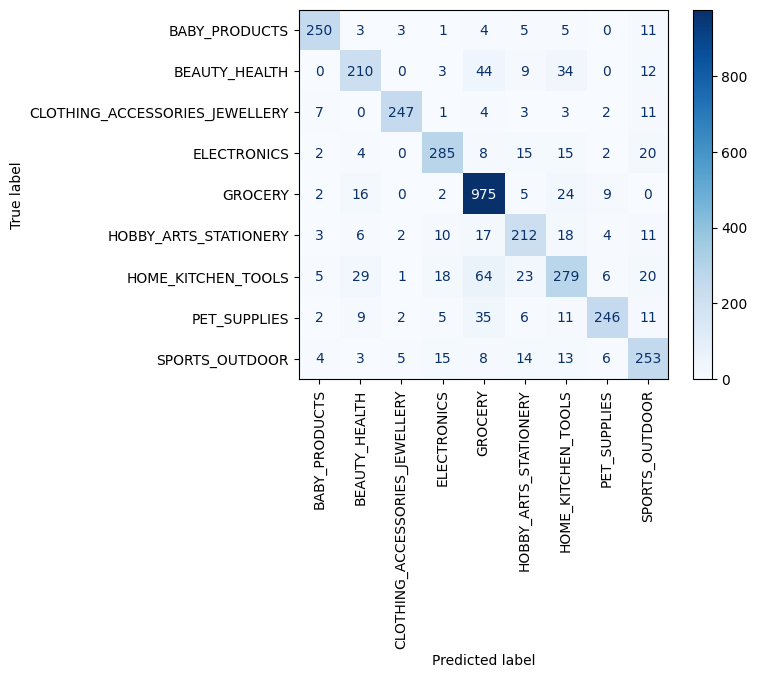

In [11]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
# Get the true labels
true_labels = val_generator.classes

# Make predictions
predictions = model.predict(val_generator, steps=len(val_generator), verbose=1)

# Convert predictions to class labels
predicted_classes = np.argmax(predictions, axis=1)

# Compute confusion matrix
conf_matrix = confusion_matrix(true_labels, predicted_classes)

# Display confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=val_generator.class_indices.keys())
disp.plot(cmap=plt.cm.Blues)
plt.xticks(rotation=90)
plt.show()

In [12]:
# Print classification report
report = classification_report(true_labels, predicted_classes, target_names=labels)
print(report)

                                precision    recall  f1-score   support

                 BABY_PRODUCTS       0.91      0.89      0.90       282
                 BEAUTY_HEALTH       0.75      0.67      0.71       312
CLOTHING_ACCESSORIES_JEWELLERY       0.95      0.89      0.92       278
                   ELECTRONICS       0.84      0.81      0.82       351
                       GROCERY       0.84      0.94      0.89      1033
         HOBBY_ARTS_STATIONERY       0.73      0.75      0.74       283
            HOME_KITCHEN_TOOLS       0.69      0.63      0.66       445
                  PET_SUPPLIES       0.89      0.75      0.82       327
                SPORTS_OUTDOOR       0.72      0.79      0.76       321

                      accuracy                           0.81      3632
                     macro avg       0.81      0.79      0.80      3632
                  weighted avg       0.81      0.81      0.81      3632



# Deployment

In [13]:
# Function to randomly select an image from the 'check' directory
def get_random_image(sample_dataset_dir):
    classes = os.listdir(sample_dataset_dir)
    selected_class = random.choice(classes)
    class_dir = os.path.join(sample_dataset_dir, selected_class)
    image_name = random.choice(os.listdir(class_dir))
    image_path = os.path.join(class_dir, image_name)
    return image_path, selected_class

# Function to preprocess the image
def preprocess_image(img_path):
    # Load the image (this itself is a printable image)
    loaded_img = image.load_img(img_path, target_size=(224, 224))
    # Convert the image to a numpy array
    img = image.img_to_array(loaded_img)
    # Reshape the image to add an extra dimension (batch size dimension)
    array_image = np.expand_dims(img, axis=0)
    # Normalize the image to the range [0, 1]
    array_image = array_image / 255.0
    return loaded_img, array_image

# Display The Image
def display_image(img, category, figsize=(5, 5)):
    "Give a loaded image and its category"
    plt.figure(figsize=figsize)
    plt.imshow(img)
    plt.title(f"Chosen Image Actual Category: {category}")
    plt.axis("off")
    plt.show()

In [14]:
def bring_predict_probas(predictions):
    class_labels = {
        "BABY_PRODUCTS": 0,
        "BEAUTY_HEALTH": 1,
        "CLOTHING_ACCESSORIES_JEWELLERY": 2,
        "ELECTRONICS": 3,
        "GROCERY": 4,
        "HOBBY_ARTS_STATIONERY": 5,
        "HOME_KITCHEN_TOOLS": 6,
        "PET_SUPPLIES": 7,
        "SPORTS_OUTDOOR": 8,
    }
    # Create a reverse mapping
    reverse_class_labels = {v: k for k, v in class_labels.items()}
    # Flatten the predictions array and sort the probabilities along with their indices
    predictions = predictions.flatten()
    sorted_indices = np.argsort(predictions)[::-1]  # Sort in descending order
    # Get sorted class labels and their corresponding probabilities
    sorted_class_labels = [reverse_class_labels[i] for i in sorted_indices]
    sorted_probabilities = np.round(predictions[sorted_indices], 2)
    return sorted_class_labels, sorted_probabilities


# Create a DataFrame
def create_dataframe(sorted_class_labels, sorted_probabilities):
    df = pd.DataFrame(
        {"Class": sorted_class_labels, "Probability": sorted_probabilities}
    )
    return df

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


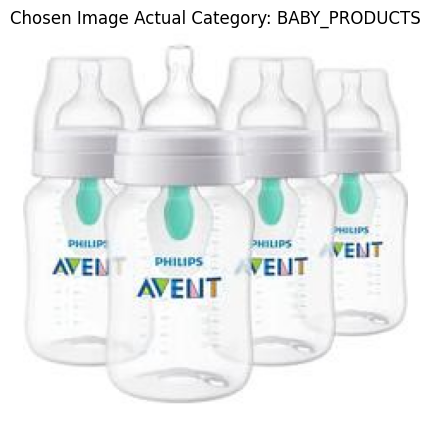

Model Predicts:   
                            Class  Probability
0                   BABY_PRODUCTS          1.0
1              HOME_KITCHEN_TOOLS          0.0
2                   BEAUTY_HEALTH          0.0
3                         GROCERY          0.0
4                  SPORTS_OUTDOOR          0.0
5  CLOTHING_ACCESSORIES_JEWELLERY          0.0
6                     ELECTRONICS          0.0
7                    PET_SUPPLIES          0.0
8           HOBBY_ARTS_STATIONERY          0.0


In [16]:
from tensorflow.keras.preprocessing import image

image_path, image_class = get_random_image(check_dir)
loaded_img, array_image = preprocess_image(image_path)
predictions = model.predict(array_image)
sorted_class_labels, sorted_probabilities = bring_predict_probas(predictions)
df = create_dataframe(sorted_class_labels, sorted_probabilities)
display_image(loaded_img, image_class)

print(f"Model Predicts:   ")
print(df)